In [1]:
!pwd

/Users/danielcohen/Documents/capstone_2


In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
import tensorflow as tf
keras = tf.keras
from keras.preprocessing.text import Tokenizer



from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Flatten, Dense

from sklearn.model_selection import train_test_split

from pipeline import vector_comparison

import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


In [4]:
from pipeline import vector_comparison

In [5]:
df = pd.read_csv('data/training.csv', index_col = 0)
#df = df.iloc[:1000] #need to limit rows while running on local machine.

In [6]:
token = Tokenizer()
model = vector_comparison(df)
X_train, X_test = model.split_data(['question1','question2'], 'is_duplicate') # ran to get self.fitting_text

y_train = model.y_train

token.fit_on_texts(model.fitting_text)
seq1 = token.texts_to_sequences(X_train['question1'].values)
seq2 = token.texts_to_sequences(X_train['question2'].values)


#vsalidation data

y_val = model.y_test

token.fit_on_texts(model.fitting_text)
seq1_val = token.texts_to_sequences(X_test['question1'].values)
seq2_val = token.texts_to_sequences(X_test['question2'].values)


In [7]:
vocab_size = len(token.index_word) + 1

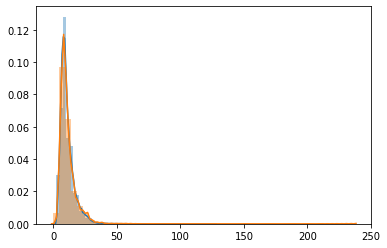

In [8]:

#average querstion lenght to set max_len
def seq_dist(seq1, seq2):
    temp1, temp2 = [], []
    for i in seq1:
        temp1.append(len(i))
    for i in seq2:
        temp2.append(len(i))
    sns.distplot(temp1)
    sns.distplot(temp2)
    return np.mean(temp1), np.mean(temp1)

seq_dist(seq1, seq2)

max_len = 30

In [9]:
from keras.preprocessing.sequence import pad_sequences

seq1_pad = pad_sequences(seq1, maxlen = max_len, padding ='pre')
seq2_pad = pad_sequences(seq2, maxlen = max_len, padding ='pre')

seq1_pad_val =pad_sequences(seq1_val, maxlen = max_len, padding ='pre')
seq2_pad_val =pad_sequences(seq2_val, maxlen = max_len, padding ='pre')

In [58]:
from keras.layers import Input, LSTM, Flatten, Dense, Concatenate, Multiply, Dropout, Subtract, Add, Embedding, Activation, GRU
from keras.layers.core import Lambda 

input_1 = Input(shape=(seq1_pad.shape[1],))
input_2 = Input(shape=(seq2_pad.shape[1],))

from sklearn.metrics import roc_auc_score as auroc

from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, RMSprop

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [110]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('src/glove.6B/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embeded_dim = len(embeddings_index['the'])
print('Loaded %s word vectors.' % len(embeddings_index))

weight_shape = embeddings_index['the'].shape[0]

Loaded 400000 word vectors.


In [111]:
weight_shape

300

In [13]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, embeded_dim))
for word, i in token.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model = Sequential()
e = Embedding(vocab_size, weight_shape, weights=[embedding_matrix], input_length=max_len, trainable=False)

common_lstm_1 = LSTM(32,return_sequences=True, activation="relu")
common_lstm_2 = LSTM(32,return_sequences=True, activation="relu")

In [ ]:
lstm_1 = e(input_1)
lstm_2 = e(input_2)

#seq1 path
vector_1 = common_lstm_1(lstm_1)
vector_1 = common_lstm_2(vector_1)
vector_1 = Flatten()(vector_1)

#seq2 path
vector_2 = common_lstm_1(lstm_2)
vector_2 = common_lstm_2(vector_2)
vector_2 = Flatten()(vector_2)


x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])



cosine_sim = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])

conc = Concatenate(axis=-1)([cosine_sim,x4, x3])


x = Dense(100, activation="relu", name='conc_layer')(conc)
x = Dropout(0.01)(x)
out = Dense(1, activation="sigmoid", name = 'out')(x)

model = Model([input_1, input_2], out)

model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.0001))

In [17]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 100)      7523400     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 30, 32)       17024       embedding_1[0][0]          

In [48]:
model.fit([seq1_pad,seq2_pad],y_train.values.reshape(-1,1), epochs = 50, batch_size = 5000,
          validation_data=([seq1_pad_val,seq2_pad_val],y_val.values.reshape(-1,1)))


Train on 242608 samples, validate on 80870 samples
Epoch 1/50
242608/242608 [==============================] - 69s 285us/step - loss: 0.3796 - acc: 0.8162 - val_loss: 0.4919 - val_acc: 0.7678
Epoch 2/50
242608/242608 [==============================] - 69s 284us/step - loss: 0.3787 - acc: 0.8177 - val_loss: 0.4932 - val_acc: 0.7691
Epoch 3/50
242608/242608 [==============================] - 68s 281us/step - loss: 0.3772 - acc: 0.8180 - val_loss: 0.4912 - val_acc: 0.7686
Epoch 4/50
242608/242608 [==============================] - 68s 280us/step - loss: 0.3770 - acc: 0.8182 - val_loss: 0.4902 - val_acc: 0.7684
Epoch 5/50
242608/242608 [==============================] - 68s 282us/step - loss: 0.3761 - acc: 0.8187 - val_loss: 0.4938 - val_acc: 0.7686
Epoch 6/50
242608/242608 [==============================] - 68s 282us/step - loss: 0.3754 - acc: 0.8190 - val_loss: 0.4916 - val_acc: 0.7693
Epoch 7/50
242608/242608 [==============================] - 68s 281us/step - loss: 0.3745 - acc: 0.8192

In [49]:
epochs = 175
model.save(f'model_{epochs}')
#keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)


In [83]:
model_history = model.history.history

In [57]:
model2 = Sequential()

In [61]:

common_GRU = GRU(32,return_sequences=True, activation="relu")


vector_1 = e(input_1)
vector_1 = common_GRU(vector_1)
vector_1 = Flatten()(vector_1)

vector_2 = e(input_2)
vector_2 = common_GRU(vector_2)
vector_2 = Flatten()(vector_2)

x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])


cosine_sim = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])

conc = Concatenate(axis=-1)([cosine_sim,x4, x3])


x = Dense(100, activation="relu", name='conc_layer')(conc)
x = Dropout(0.01)(x)
out = Dense(1, activation="sigmoid", name = 'out')(x)

model2 = Model([input_1, input_2], out)

model2.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.0001))

In [62]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 100)      7523400     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 30, 32)       12768       embedding_1[2][0]          

In [100]:
model2.fit([seq1_pad,seq2_pad],y_train.values.reshape(-1,1), epochs = 50, batch_size = 500,
          validation_data=([seq1_pad_val,seq2_pad_val],y_val.values.reshape(-1,1)))


Train on 242608 samples, validate on 80870 samples
Epoch 1/50
242608/242608 [==============================] - 43s 179us/step - loss: 0.3102 - acc: 0.8576 - val_loss: 0.5477 - val_acc: 0.7685
Epoch 2/50
242608/242608 [==============================] - 45s 184us/step - loss: 0.2977 - acc: 0.8645 - val_loss: 0.5614 - val_acc: 0.7694
Epoch 3/50
242608/242608 [==============================] - 45s 185us/step - loss: 0.2925 - acc: 0.8677 - val_loss: 0.5674 - val_acc: 0.7699
Epoch 4/50
242608/242608 [==============================] - 46s 190us/step - loss: 0.2890 - acc: 0.8703 - val_loss: 0.5661 - val_acc: 0.7700
Epoch 5/50
242608/242608 [==============================] - 44s 183us/step - loss: 0.2863 - acc: 0.8710 - val_loss: 0.5717 - val_acc: 0.7704
Epoch 6/50
242608/242608 [==============================] - 44s 181us/step - loss: 0.2833 - acc: 0.8728 - val_loss: 0.5757 - val_acc: 0.7672
Epoch 7/50
242608/242608 [==============================] - 45s 184us/step - loss: 0.2811 - acc: 0.8737

In [102]:
epochs2 = 50
model.save(f'model2.slow_{epochs2}')

model2_slow_history =[]
model2_slow_history.append(model2.history.history)

model2_slow_val_acc = model2_slow_history[-1]['val_acc']
model1_val_acc = model_history['val_acc']


model1_val_loss = model_history['val_loss']
model2_slow_val_loss = model2_slow_history[-1]['val_acc']

model

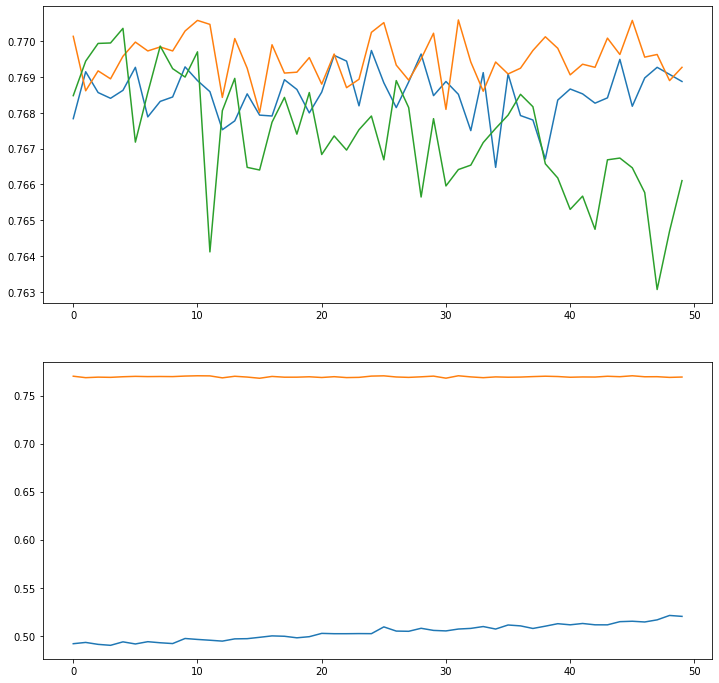

In [104]:
fig, ax = plt.subplots(2,1,figsize=(12,12))

ax[0].plot(model1_val_acc)
ax[0].plot(model2_val_acc)
ax[0].plot(model2_slow_val_acc)

ax[1].plot(model1_val_loss)
ax[1].plot(model2_val_loss)

In [84]:
model_history

{'val_loss': [0.4918635563803527,
  0.49319574148056167,
  0.4911749103506519,
  0.49018181198029787,
  0.49379046834914075,
  0.4915957327264635,
  0.4939584912152053,
  0.4928412670970951,
  0.492015838917864,
  0.49728715942332574,
  0.496306706155881,
  0.4954777990907884,
  0.49455352544533954,
  0.4968928161953706,
  0.4971027302405913,
  0.4985176687653639,
  0.49999978124940586,
  0.4995991727898085,
  0.49799453643191743,
  0.4991702787164441,
  0.5026024326127466,
  0.5022648906470436,
  0.5022657501494117,
  0.5023881374750412,
  0.502313144329055,
  0.5093571039408913,
  0.5049976796681999,
  0.5047713961547601,
  0.5079039679376101,
  0.5056969933999518,
  0.5051708208500447,
  0.5071207936325725,
  0.5077945317092307,
  0.5097184305183965,
  0.5071163755258022,
  0.511324515157862,
  0.5104097006449788,
  0.5077282486982571,
  0.5101083561444557,
  0.5126780456159353,
  0.5115127751569865,
  0.512895780904222,
  0.5115165153097514,
  0.5114866002124571,
  0.51479507797180

In [108]:
model3 = Sequential()

In [114]:

common_GRU = GRU(32,return_sequences=True, activation="relu")


vector_1 = e(input_1)
vector_1 = common_GRU(vector_1)
#vector_1 = common_GRU(vector_1)
vector_1 = Flatten()(vector_1)

vector_2 = e(input_2)
vector_2 = common_GRU(vector_2)
#vector_2 = common_GRU(vector_2)
vector_2 = Flatten()(vector_2)

x3 = Subtract()([vector_1, vector_2])
x3 = Multiply()([x3, x3])

x1_ = Multiply()([vector_1, vector_1])
x2_ = Multiply()([vector_2, vector_2])
x4 = Subtract()([x1_, x2_])


cosine_sim = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([vector_1, vector_2])

conc = Concatenate(axis=-1)([cosine_sim,x4, x3])


x = Dense(100, activation="relu", name='conc_layer')(conc)
x = Dropout(0.01)(x)
out = Dense(1, activation="sigmoid", name = 'out')(x)

model3 = Model([input_1, input_2], out)

model3.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.0001))

In [116]:
model3.fit([seq1_pad,seq2_pad],y_train.values.reshape(-1,1), epochs = 50, batch_size = 500,
          validation_data=([seq1_pad_val,seq2_pad_val],y_val.values.reshape(-1,1)))

Train on 242608 samples, validate on 80870 samples
Epoch 1/50
242608/242608 [==============================] - 48s 196us/step - loss: 0.5984 - acc: 0.6494 - val_loss: 0.5699 - val_acc: 0.6921
Epoch 2/50
242608/242608 [==============================] - 47s 194us/step - loss: 0.5510 - acc: 0.7097 - val_loss: 0.5456 - val_acc: 0.7153
Epoch 3/50
242608/242608 [==============================] - 46s 189us/step - loss: 0.5281 - acc: 0.7264 - val_loss: 0.5299 - val_acc: 0.7255
Epoch 4/50
242608/242608 [==============================] - 46s 189us/step - loss: 0.5120 - acc: 0.7376 - val_loss: 0.5189 - val_acc: 0.7331
Epoch 5/50
242608/242608 [==============================] - 47s 193us/step - loss: 0.4995 - acc: 0.7460 - val_loss: 0.5117 - val_acc: 0.7387
Epoch 6/50
242608/242608 [==============================] - 46s 189us/step - loss: 0.4892 - acc: 0.7519 - val_loss: 0.5036 - val_acc: 0.7441
Epoch 7/50
242608/242608 [==============================] - 46s 190us/step - loss: 0.4800 - acc: 0.7577

KeyboardInterrupt: 